# Datathon Novartis 2022
___


The code presented in this notebook is the result of the work of the @Shamballa team composed of :

- Walid Ider
- Marie Mayol
- Eric Diez
- Yannig Delorme


During this Edition of the Datathon Novartis that took place remotely on Microsoft Teams.

This Datathon was also a part of the seminars of the SIRI-MIRI course of the Barcelona School of Informatics .

We were ranked 17th out of more than 60 teams.

___

## Subject : The Financial Challenge

**The technical challenge is split into two parts, each of them evaluated separately although a strong
performance in each of them is required in order to get to the final of the Datathon.
Although, as we have already seen, there may be more than one transition moment, for this challenge we
will focus only on the first transition from growth to maturity.**


- Part 1: Predict transition moment

Predict if there will be a transition to maturity happening for each of the brands during the defined time
period, which is in the upcoming 37 months. In case there is, it is important to provide a prediction as to
when it will happen.


- Part 2: Predict stabilization upon transition

Provide the sales forecast for the same forecasting horizon. Adjust the benchmark forecast, which will be
provided to you, based on the expected transition point in time from the first part. 


___

# Importing the necessary libraries

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import warnings
warnings.filterwarnings("ignore")
import seaborn as sb
import sklearn as sk
import itertools as it
import scipy.stats as stats
import time
import math

import scipy.stats as sps
import numpy.random as npr
import seaborn as sns
import random

from IPython.display import clear_output

from scipy.stats import multivariate_normal

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 10)  #set default figure size
from numba import njit
import statsmodels.api as sm

import os
from math import e
import glob
from typing import Optional, Union, Tuple


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import LabelEncoder

# Necessary scoring functions we are going to need later :

In [2]:
def compute_exponential_time_mape(
    submission,
    ground_truth,
    forecast_horizon=37,
):
    # Deal with date type
    submission['transition_date'] = pd.to_datetime(submission['transition_date'])
    ground_truth["transition_date"] = pd.to_datetime(ground_truth["transition_date"])

    # Rename columns
    ground_truth.rename(
        columns={"transition_date": "real_date", "is_transition": "real_transition"}, inplace=True
    )

    df = ground_truth[["cluster_id", "real_date", "real_transition"]].merge(
        submission[["cluster_id", "transition_date", "is_transition"]], on="cluster_id", how="left"
    )

    # Compute time-error
    time_error = abs(np.round((df["real_date"] - df["transition_date"]) / np.timedelta64(1, "M")))

    df["error"] = time_error / forecast_horizon

    df["exp_error"] = e ** (df["error"])

    # normalize with min max
    df["norm_error"] = (df["exp_error"] - e ** (0)) / (e ** (1) - e ** (0))

    # penalize wrong is_transition value
    df.loc[df["is_transition"] != df["real_transition"], "norm_error"] = 1.0

    # If length of unique transition dates is lower than 1, provide 100% errors
    if len(np.unique(df['transition_date'])) == 1:
        return 1

    return np.mean(df["norm_error"])

In [3]:
def penalized_mape_error(
    submission_one: pd.DataFrame,
    submission_two: pd.DataFrame,
    ground_truth: pd.DataFrame,
    benchmark: pd.DataFrame,
    penalization_factor: int = 1,
):
    # Deal with date type
    submission_two['date'] = pd.to_datetime(submission_two['date'])
    submission_one['transition_date'] = pd.to_datetime(submission_one['transition_date'])
    benchmark['date'] = pd.to_datetime(benchmark['date'])
    ground_truth["date"] = pd.to_datetime(ground_truth["date"])

    benchmark.rename(columns={"forecast": "benchmark_fcst"}, inplace=True)

    # Merge to know the transition_date
    submission_two = submission_two.merge(submission_one, on="cluster_id", how="left")
    submission_two = submission_two.merge(benchmark, on=["cluster_id", "date"], how="left")

    # Check those conditions in which a penalization is needed
    cond_one = submission_two["date"] < submission_two["transition_date"]
    cond_two = submission_two["benchmark_fcst"] != submission_two["forecast"]
    cond_three = submission_two["is_transition"] == "YES"
    submission_two["penalization"] = np.where(cond_one & cond_two & cond_three, "YES", "NO")

    # Rename columns
    ground_truth.rename(columns={"volume": "real_actuals"}, inplace=True)

    df = ground_truth[["cluster_id", "date", "real_actuals"]].merge(
        submission_two[["cluster_id", "date", "forecast","penalization"]],
        on=["cluster_id", "date"],
        how="left",
    )

    # Compute ape per cluster-id-date
    df["error_method"] = abs(df["forecast"] - df["real_actuals"]) / df["real_actuals"]

    df["error_method"] = np.where(df["penalization"] == "YES", penalization_factor, df["error_method"])

    return np.mean(df["error_method"])

# Importing the Data 

In [4]:
path1 = '.'
os.chdir(path1)

files = glob.glob('*.csv')

print("Here is the list of DataFrames:")
print("_______________________________")
for x in files : 
    locals()[x[0:len(x)-4]] = pd.read_csv(x)
    try:
        locals()[x[0:len(x)-4]].drop(columns=["Unnamed: 0"],inplace=True)
    except:
        pass
    print(x[0:len(x)-4])

Here is the list of DataFrames:
_______________________________
regulatory_designations
generics_dates
competitor_dates
benchmark
submission_metric_two_sample
indication_dates
population
launch_dates
submission_metric_one_template
submission_metric_one_sample
candidates_df
submission_metric_two_template
Attempt_Metric2


In [5]:
#Importing the samples

path1 = '.'
os.chdir(path1)

files = glob.glob('*.csv')

print("Here is the list of DataFrames:")
print("_______________________________")
for x in files : 
    try:
        locals()[x[0:len(x)-4]] = pd.read_csv(x)
        print(x[0:len(x)-4])
        try:
            locals()[x[0:len(x)-4]].drop(columns=["Unnamed: 0"],inplace=True)
        except:
            pass
    except:
        pass

Here is the list of DataFrames:
_______________________________
regulatory_designations
generics_dates
competitor_dates
benchmark
submission_metric_two_sample
indication_dates
population
launch_dates
submission_metric_one_template
submission_metric_one_sample
candidates_df
submission_metric_two_template
Attempt_Metric2


In [6]:
candidates_df.describe()

,volume,ther_area_fact,prevalence
count,1.473970e+05,147397.000000,147397.000000
mean,8.316555e+10,4.587665,-0.841995
std,5.787569e+11,3.394663,0.369732
min,-1.000000e+00,0.000000,-1.000000
25%,-1.000000e+00,2.000000,-1.000000
50%,2.368016e+07,2.000000,-1.000000
75%,4.389145e+09,7.000000,-1.000000
max,2.440992e+13,11.000000,1.000000


In [7]:
benchmark

,cluster_id,date,forecast
0,ID_35,2019-04-01,4.018972e+10
1,ID_35,2019-05-01,4.063665e+10
2,ID_35,2019-06-01,3.497603e+10
3,ID_35,2019-07-01,3.905927e+10
4,ID_35,2019-08-01,4.259741e+10
...,...,...,...
8357,ID_3218,2021-12-01,1.659180e+07
8358,ID_3218,2022-01-01,1.722303e+07
8359,ID_3218,2022-02-01,1.599008e+07
8360,ID_3218,2022-03-01,1.516530e+07


In [8]:
population

,country,year,population
0,country_1,2018,0.012173
1,country_38,2002,0.010285
2,country_15,2016,0.051458
3,country_38,2010,0.010942
4,country_21,2016,0.036696
...,...,...,...
340,country_37,2016,0.000848
341,country_22,2002,0.082792
342,country_21,2017,0.036703
343,country_16,2008,0.002672


<AxesSubplot:>

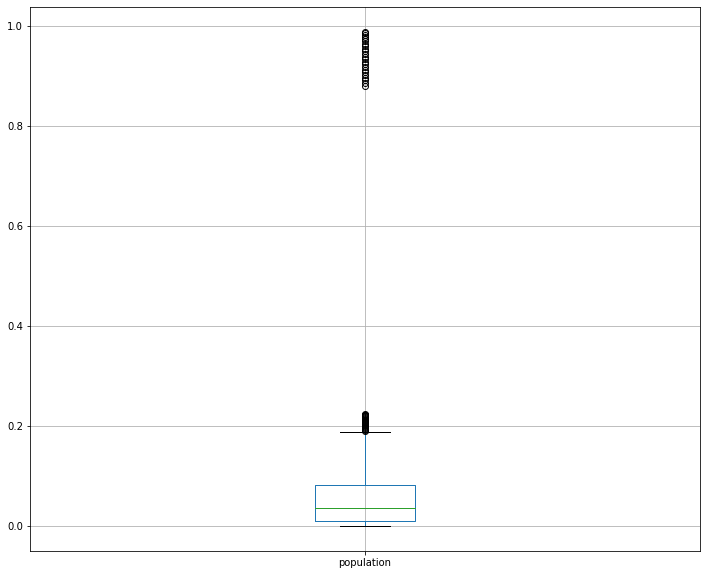

In [9]:
pd.DataFrame(population['population']).boxplot()

<AxesSubplot:>

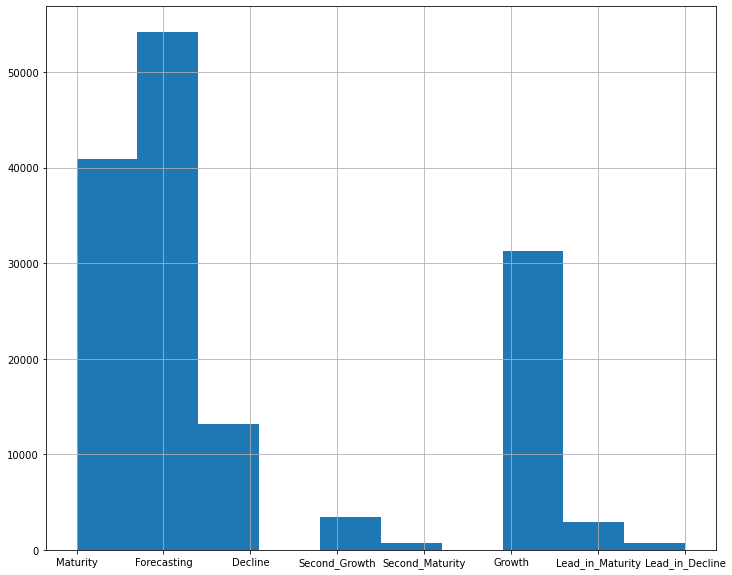

In [10]:
candidates_df["stage_name"].hist()

# First Part:

Modelization for the first metric

___

# Data Preprocessing

**What we need to do is to prepare our data so that it is suitable for our classification**

In [11]:
df=submission_metric_one_sample

In [12]:
df=candidates_df.merge(df,on='cluster_id',how='left')

In [13]:
df

df.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None,
    inplace=True
)


In [14]:
def MassLabelEncoding(df) : 
    """
    Label Encoding on all string columns 
    of a non-empty DataFrame
    """
    le=LabelEncoder()
    firstRow = list(df.iloc[0])
    for i in range(len(firstRow)) : 
        if type(firstRow[i]) == str : 
            currentColumn = list(df.columns)[i]
            df[currentColumn] = le.fit_transform(df[currentColumn])
    return df


In [15]:
le=LabelEncoder()
firstRow = list(df.iloc[0])
for i in range(len(firstRow)) : 
    if type(firstRow[i]) == str : 
        currentColumn = list(df.columns)[i]
        df[currentColumn] = le.fit_transform(df[currentColumn])
        


In [16]:
try:
    X=df.drop(columns=["transition_date","is_transition"])
except:
    pass
y=df["is_transition"]
y

2278      1
2279      1
2280      1
2281      1
2282      1
         ..
147305    1
147306    1
147307    1
147308    1
147309    1
Name: is_transition, Length: 20025, dtype: int64

# Preparing the Data for Classification

- We are going to use a Random Forest Classifier, as in this case it is the most suitable one

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
clf = RandomForestClassifier(criterion="entropy",max_depth=1)

In [19]:
clf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=1)

In [20]:
clf.score(X_test,y_test)

0.9969738235739144

In [21]:
df_f=submission_metric_one_template
df_f

,cluster_id,transition_date,is_transition
0,ID_35,NaN,NaN
1,ID_38,NaN,NaN
2,ID_39,NaN,NaN
3,ID_41,NaN,NaN
4,ID_62,NaN,NaN
...,...,...,...
221,ID_3117,NaN,NaN
222,ID_3183,NaN,NaN
223,ID_3187,NaN,NaN
224,ID_3192,NaN,NaN


In [22]:
df=submission_metric_one_sample
df=candidates_df.merge(df,on='cluster_id',how='left')
df=df.reset_index().drop(columns="index")


df_pred=df[df["cluster_id"]==df_f["cluster_id"].unique()[0]]
for x in df_f["cluster_id"].unique()[1:len(df_f["cluster_id"].unique())]:
    df_pred=pd.concat([df_pred,df[df["cluster_id"]==x]],ignore_index=True)
    

In [23]:
save=df_pred.copy()


In [24]:
X=df_pred.drop(columns=['is_transition',"transition_date"])

In [25]:
firstRow = list(X.iloc[0])
for i in range(len(firstRow)) : 
    if type(firstRow[i]) == str : 
        currentColumn = list(X.columns)[i]
        X[currentColumn] = le.fit_transform(X[currentColumn])

In [26]:
y_transition=clf.predict(X)

In [27]:
y_transition=list(y_transition)
for i in range(len(y_transition)):
    if y_transition[i]==1 : 
        y_transition[i]= "YES"
    else:
        y_transition[i]="NO"

In [28]:
y_transition = pd.DataFrame(y_transition)

In [29]:
y_transition.describe()

,0
count,20025
unique,1
top,YES
freq,20025


In [30]:
try:
    y_tr=[]
    tmp=0
    for x in X['cluster_id'].unique():
        tmp = X[X["cluster_id"]==x]["is_transition"]
        tmp=np.sum(tmp)/len(tmp)
        if tmp > 0.5:
            y_tr.append("YES")
        else:
            y_tr.append("NO")
except:
    pass

In [31]:
#submission_metric_one_template["is_transition"]=y_tr

In [32]:
submission_metric_one_template

for i in range(len(submission_metric_one_template)):
    submission_metric_one_template["transition_date"][i]=random.choice(df.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None
)["transition_date"].unique())

In [33]:
df.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None
)


,country,cluster,cluster_id,date,stage_name,stage_name_lag_1,volume,business_unit,ther_area_fact,prevalence,transition_date,is_transition
2278,country_0,brand_27,ID_35,2016-05-01,Growth,No_Stage,5.997878e+09,TWO,10,-1.0,2023-04-01,YES
2279,country_0,brand_27,ID_35,2016-06-01,Growth,No_Stage,3.362598e+09,TWO,10,-1.0,2023-04-01,YES
2280,country_0,brand_27,ID_35,2016-07-01,Growth,No_Stage,3.631606e+09,TWO,10,-1.0,2023-04-01,YES
2281,country_0,brand_27,ID_35,2016-08-01,Growth,No_Stage,6.286812e+09,TWO,10,-1.0,2023-04-01,YES
2282,country_0,brand_27,ID_35,2016-09-01,Growth,No_Stage,8.553452e+09,TWO,10,-1.0,2023-04-01,YES
...,...,...,...,...,...,...,...,...,...,...,...,...
147305,country_34,brand_51,ID_3218,2021-12-01,Forecasting,Forecasting,-1.000000e+00,TWO,1,-1.0,2023-04-01,YES
147306,country_34,brand_51,ID_3218,2022-01-01,Forecasting,Forecasting,-1.000000e+00,TWO,1,-1.0,2023-04-01,YES
147307,country_34,brand_51,ID_3218,2022-02-01,Forecasting,Forecasting,-1.000000e+00,TWO,1,-1.0,2023-04-01,YES
147308,country_34,brand_51,ID_3218,2022-03-01,Forecasting,Forecasting,-1.000000e+00,TWO,1,-1.0,2023-04-01,YES


In [34]:
for i in range(len(submission_metric_one_template)):
    if submission_metric_one_template["is_transition"][i]=="NO":
        submission_metric_one_template["transition_date"][i]="2019-04-01"

In [35]:
saving = 0
if saving == 1:    
    submission_metric_one_sample.to_csv("Attempt_1.csv")

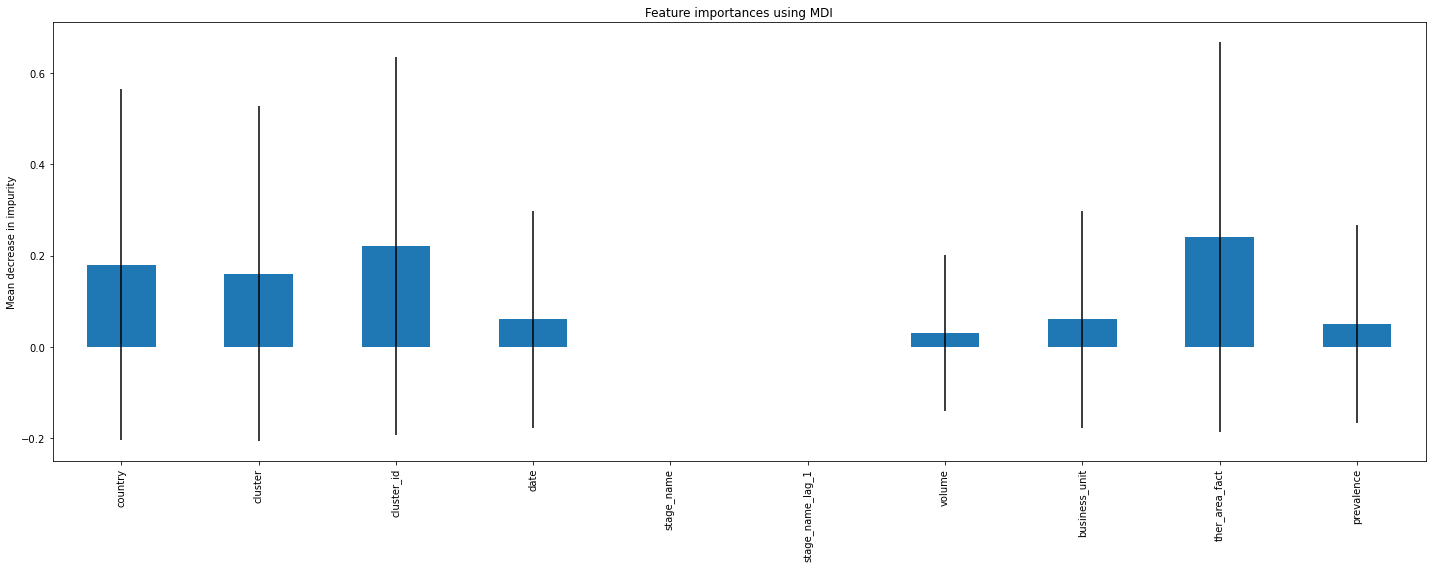

In [36]:
X=pd.DataFrame(X)

features= list(X.columns)
start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots(figsize=(20,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [37]:
def check_early_stopping(
    scores: Union[list, np.ndarray],
    metric: str,
    stopping_rounds: int=4,
    stopping_tolerance: float=0.01,
    max_runtime_sec: int=None,
    start_time: pd.Timestamp=None) -> bool:
    
    """
    Check if early stopping condition is met.
    
    Parameters
    ----------
    
    scores: list, np.ndarray
        Scores used to evaluate early stopping conditions.
        
    metric: str
        Metric which scores referes to. Used to determine if higher score
        means a better model or the opposite.
        
    stopping_rounds: int, default 4
        Number of consecutive rounds without improvement needed to stop
        the training.
    
    stopping_tolerance: float, default 0.01
        Minimum percentage of positive change between two consecutive rounds
        needed to consider it as an improvement.
    
    max_runtime_sec: int, default `None`
        Maximum allowed runtime in seconds for model training. `None` means unlimited.
    
    start_time: pd.Timestamp, default `None`
        Time when training started. Used to determine if `max_runtime_sec` has been
        reached.
        
        
    Returns
    ------
    bool:
        `True` if any condition needed for early stopping is met. `False` otherwise.
        
    Notes
    -----
    
    Example of early stopping:
        
    Stop after 4 rounds without an improvement of 1% or higher: `stopping_rounds` = 4,
    `stopping_tolerance` = 0.01, `max_runtime_sec` = None.
    
    """
    
    allowed_metrics = ['accuracy', 'auc', 'f1', 'mse', 'mae', 'squared_error',
                       'absolute_error']
    
    if metric not in allowed_metrics:
        raise Exception(
                f"`metric` argument must be one of: {allowed_metrics}. "
                f"Got {metric}"
        )
    
    if isinstance(scores, list):
        scores = np.array(scores)
        
    if max_runtime_sec is not None:
        
        if start_time is None:
            start_time = pd.Timestamp.now()
            
        runing_time = (pd.Timestamp.now() - start_time).total_seconds()
        
        if runing_time > max_runtime_sec:
            logging.debug(
                f"Reached maximum time for training ({max_runtime_sec} seconds). "
                f"Early stopping activated."
            )
            return True
        
    if len(scores) < stopping_rounds:
        return False
    
    if metric in ['accuracy', 'auc', 'f1']:
        # The higher the metric, the better
        diff_scores = scores[1:] - scores[:-1]
        improvement = diff_scores / scores[:-1]
        
    if metric in ['mse', 'mae', 'squared_error', 'absolute_error']:
        # The lower the metric, the better
        
        # scores = -1 * scores 
        # diff_scores = scores[:-1] - scores[1:]
        # improvement = diff_scores / scores[1:]
        diff_scores = scores[1:] - scores[:-1]
        improvement = diff_scores / scores[:-1]
        improvement = -1 * improvement
        
    improvement = np.hstack((np.nan, improvement))
    logging.debug(f"Improvement: {improvement}")
    
    if (improvement[-stopping_rounds:] < stopping_tolerance).all():
        return True
    else:
        return False


    
def fit_RandomForest_early_stopping(
    model: Union[RandomForestClassifier, RandomForestRegressor],
    X: Union[np.ndarray, pd.core.frame.DataFrame],
    y: np.ndarray,
    metric: str,
    positive_class: int=1,
    score_tree_interval: int=None,
    stopping_rounds: int=4,
    stopping_tolerance: float=0.01,
    max_runtime_sec: int=None) -> np.ndarray:
    
    """
    Fit a RandomForest model until an early stopping condition is met or
    `n_estimatos` is reached.
    
    Parameters
    ----------
    
    model: RandomForestClassifier, RandomForestRegressor
        Model to be fitted.
        
    X: np.ndarray, pd.core.frame.DataFrame
        Training input samples. 
    
    y: np.ndarray, pd.core.frame.DataFrame
        Target value of the input samples. 
    
    scores: list, np.ndarray
        Scores used to evaluate early stopping conditions.
        
    metric: str
        Metric used to generate the score. Used to determine if higher score
        means a better model or the opposite.
        
    score_tree_interval: int, default `None`
        Score the model after this many trees. If `None`, the model is scored after
        `n_estimators` / 10.
        
    stopping_rounds: int
        Number of consecutive rounds without improvement needed to stop the training.
    
    stopping_tolerance: float, default 0.01
        Minimum percentage of positive change between two consecutive rounds
        needed to consider it as an improvement. 
    
    max_runtime_sec: int, default `None`
        Maximum allowed runtime in seconds for model training. `None` means unlimited.
        
        
    Returns
    ------
    oob_scores: np.ndarray
        Out of bag score for each scoring point.
    
    """
    
    if score_tree_interval is None:
        score_tree_interval = int(model.n_estimators / 10)
        
    allowed_metrics = ['accuracy', 'auc', 'f1', 'mse', 'mae', 'squared_error',
                       'absolute_error']
    
    if metric not in allowed_metrics:
        raise Exception(
                f"`metric` argument must be one of: {allowed_metrics}. "
                f"Got {metric}"
        )
    
    if not model.oob_score:
        model.set_params(oob_score=True)
        
    start_time = pd.Timestamp.now()
    oob_scores = []
    scoring_points = np.arange(0, model.n_estimators + 1, score_tree_interval)[1:]
    scoring_points = np.hstack((1, scoring_points))
    
    metrics = {
        'auc' : roc_auc_score,
        'accuracy' : accuracy_score,
        'f1': f1_score,
        'mse': mean_squared_error,
        'squared_error': mean_squared_error,
        'mae': mean_absolute_error,
        'absolute_error': mean_absolute_error,        
    }
    
    for i, n_estimators in enumerate(scoring_points):
        
        logging.debug(f"Training with n_stimators: {n_estimators}")
        model.set_params(n_estimators=n_estimators)
        model.fit(X=X, y=y)
        
        if metric == 'auc':
            oob_predictions = model.oob_decision_function_[:, positive_class]
            # If n_estimators is small it might be possible that a data point
            # was never left out during the bootstrap. In this case,
            # oob_decision_function_ might contain NaN.
            oob_score = metrics[metric](
                            y_true=y[~np.isnan(oob_predictions)],
                            y_score=oob_predictions[~np.isnan(oob_predictions)]
                        )
        else:
            oob_predictions = model.oob_decision_function_
            oob_predictions = np.argmax(oob_predictions, axis=1)
            oob_score = metrics[metric](
                            y_true=y[~np.isnan(oob_predictions)],
                            y_score=oob_predictions[~np.isnan(oob_predictions)]
                        )
            
        oob_scores.append(oob_score)
        
        early_stopping = check_early_stopping(
                            scores             = oob_scores,
                            metric             = metric,
                            stopping_rounds    = stopping_rounds,
                            stopping_tolerance = stopping_tolerance,
                            max_runtime_sec    = max_runtime_sec,
                            start_time         = start_time
                         )    
        
        if early_stopping:
            logging.debug(
                f"Early stopping activated at round {i + 1}: n_estimators = {n_estimators}"
            )
            break
        
    logging.debug(f"Out of bag score = {oob_scores[-1]}")
    
    return np.array(oob_scores), scoring_points[:len(oob_scores)]

In [38]:
def custom_gridsearch_RandomForestClassifier(
    model: RandomForestClassifier,
    X: Union[np.ndarray, pd.core.frame.DataFrame],
    y: np.ndarray,
    metric: str,
    param_grid: dict,
    positive_class: int=1,
    score_tree_interval: int=None,
    stopping_rounds: int=5,
    stopping_tolerance: float=0.01,
    model_max_runtime_sec: int=None,
    max_models: int=None,
    max_runtime_sec: int=None,
    return_best: bool=True) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    '''
    Grid search for RandomForestClassifier model based on out-of-bag metric and 
    early stopping for each model fit.
    
    Parameters
    ----------
    
    model: RandomForestClassifier
        Model to search over.
           
    X: np.ndarray, pd.core.frame.DataFrame
        The training input samples. 
    
    y: np.ndarray, pd.core.frame.DataFrame
        The target of input samples. 
    
    scores: list, np.ndarray
        Scores used to evaluate early stopping conditions.
        
    metric: str
        Metric used to generate the score. I is used to determine if higher score
        means a better model or the opposite.
        
    score_tree_interval: int, default `None`
        Score the model after this many trees. If `None`, the model is scored after
        `n_estimators` / 10.
        
    stopping_rounds: int
        Number of consecutive rounds without improvement needed to stop the training.
    
    stopping_tolerance: float, default 0.01
        Minimum percentage of positive change between two consecutive rounds
        needed to consider it as an improvement. 
    
    model_max_runtime_sec: int, default `None`
        Maximum allowed runtime in seconds for model training. `None` means unlimited.
        
    max_models: int, default `None`
        Maximum number of models trained during the search.
    
    max_runtime_sec: int, default `None`
        Maximum number of seconds for the search.
        
    return_best : bool
        Refit model using the best found parameters on the whole data.
        
        
    Returns
    ------
    
    results: pd.DataFrame
    
    '''
    
    results = {'params': [], 'oob_metric': []}
    start_time = pd.Timestamp.now()
    history_scores = {}
    history_scoring_points = np.array([], dtype = int)
    param_grid = list(ParameterGrid(param_grid))
    
    if not model.oob_score:
        model.set_params(oob_score=True)
    
    if max_models is not None and max_models < len(param_grid):
        param_grid = np.random.choice(param_grid, max_models)

    for params in tqdm.tqdm(param_grid):
        
        if max_runtime_sec is not None:
            runing_time = (pd.Timestamp.now() - start_time).total_seconds()
            if runing_time > max_runtime_sec:
                logging.info(
                    f"Reached maximum time for GridSearch ({max_runtime_sec} seconds). "
                    f"Search stopped."
                )
                break   
        
        model.set_params(**params)

        oob_scores, scoring_points = fit_RandomForest_early_stopping(
                                        model = clone(model), # Clone to avoid modification of n_estimators
                                        X = X,
                                        y = y,
                                        metric = metric,
                                        positive_class      = positive_class,
                                        score_tree_interval = score_tree_interval,
                                        stopping_rounds     = stopping_rounds,
                                        stopping_tolerance  = stopping_tolerance,
                                        max_runtime_sec     = model_max_runtime_sec
                                     )
      
        history_scoring_points = np.union1d(history_scoring_points,  scoring_points)        
        history_scores[str(params)] = oob_scores
        params['n_estimators'] = scoring_points[-1]
        results['params'].append(params)
        results['oob_metric'].append(oob_scores[-1])
        logging.debug(f"Modelo: {params} \u2713")

    results = pd.DataFrame(results)
    history_scores = pd.DataFrame(
                            dict([(k, pd.Series(v)) for k,v in history_scores.items()])
                         )
    history_scores['n_estimators'] = history_scoring_points
    
    if metric in ['accuracy', 'auc', 'f1']:
        results = results.sort_values('oob_metric', ascending=False)
    else:
        results = results.sort_values('oob_metric', ascending=True)
        
    results = results.rename(columns = {'oob_metric': f'oob_{metric}'})
    
    if return_best:
        best_params = results['params'].iloc[0]
        print(
            f"Refitting mode using the best found parameters and the whole data set: \n {best_params}"
        )
        
        model.set_params(**best_params)
        model.fit(X=X, y=y)
        
    results = pd.concat([results, results['params'].apply(pd.Series)], axis=1)
    results = results.drop(columns = 'params')
    
    return results, history_scores

In [39]:
param_grid = {
             'max_depth'   : [1, 3, 10, 15, 20],
             'max_features': ['sqrt', 'log2'],
             'ccp_alpha': [0, 0.01]
            }
clf= RandomForestClassifier(
            n_estimators = 100,
            oob_score    = True,
            n_jobs       = -1,
            random_state = 0
        )

gridsearch =0 # Executing a Grid Search is quite time consuming :) 

if gridsearch ==1: 

    start = pd.Timestamp.now()

    results, history = custom_gridsearch_RandomForestClassifier(
                            model                 = clf,
                            X                     = X,
                            y                     = y,
                            metric                = 'auc',
                            param_grid            = param_grid,
                            positive_class        = 1,
                            score_tree_interval   = 50,
                            stopping_rounds       = 4,
                            stopping_tolerance    = 0.01,
                            model_max_runtime_sec = None,
                            max_models            = None,
                            max_runtime_sec       = None,
                            return_best           = True
                          )

    end = pd.Timestamp.now()

    print("Duration : ", end - start)


# SECOND PART

Working now on the second metric 
___

In [40]:
benchmark.describe()

,forecast
count,8.362000e+03
mean,1.156069e+11
std,7.476571e+11
min,1.012438e+06
25%,1.933341e+08
50%,1.188627e+09
75%,1.231280e+10
max,1.580300e+13


In [41]:
benchmark = MassLabelEncoding(benchmark)

In [42]:
benchmark

,cluster_id,date,forecast
0,170,0,4.018972e+10
1,170,1,4.063665e+10
2,170,2,3.497603e+10
3,170,3,3.905927e+10
4,170,4,4.259741e+10
...,...,...,...
8357,165,32,1.659180e+07
8358,165,33,1.722303e+07
8359,165,34,1.599008e+07
8360,165,35,1.516530e+07


array([[<AxesSubplot:title={'center':'volume'}>]], dtype=object)

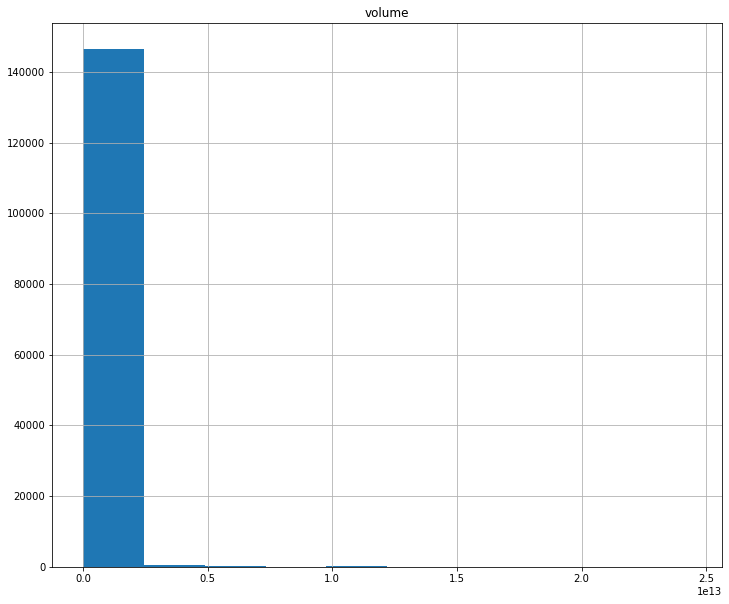

In [43]:
pd.DataFrame(candidates_df['volume']).hist()

## Preparing the data for classification

In [44]:
df_train = candidates_df.drop(columns=['volume'])

In [45]:
df=submission_metric_two_template
le=LabelEncoder()
firstRow = list(df.iloc[0])
for i in range(len(firstRow)) : 
    if type(firstRow[i]) == str : 
        currentColumn = list(df.columns)[i]
        df[currentColumn] = le.fit_transform(df[currentColumn])

In [46]:
df

,cluster_id,date,forecast
0,170,0,NaN
1,170,1,NaN
2,170,2,NaN
3,170,3,NaN
4,170,4,NaN
...,...,...,...
8357,165,32,NaN
8358,165,33,NaN
8359,165,34,NaN
8360,165,35,NaN


In [47]:
firstRow = list(df_train.iloc[0])
for i in range(len(firstRow)) : 
    if type(firstRow[i]) == str : 
        currentColumn = list(df_train.columns)[i]
        df_train[currentColumn] = le.fit_transform(df_train[currentColumn])

In [48]:
df_train

,country,cluster,cluster_id,date,stage_name,stage_name_lag_1,business_unit,ther_area_fact,prevalence
0,0,98,1010,0,5,6,1,1,-1.0
1,0,98,1010,1,5,6,1,1,-1.0
2,0,98,1010,2,5,6,1,1,-1.0
3,0,98,1010,3,5,6,1,1,-1.0
4,0,98,1010,4,5,6,1,1,-1.0
...,...,...,...,...,...,...,...,...,...
147392,28,19,1138,119,1,1,1,7,-1.0
147393,28,19,1138,120,1,1,1,7,-1.0
147394,28,19,1138,121,1,1,1,7,-1.0
147395,28,19,1138,122,1,1,1,7,-1.0


In [49]:
X=df_train
y= candidates_df['volume']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [51]:
reg=RandomForestRegressor()

In [52]:
reg.fit(X_train,y_train)

RandomForestRegressor()

In [53]:
reg.score(X_test,y_test)

0.9449265557052363

**The score of nearly 95% is quite suitable**

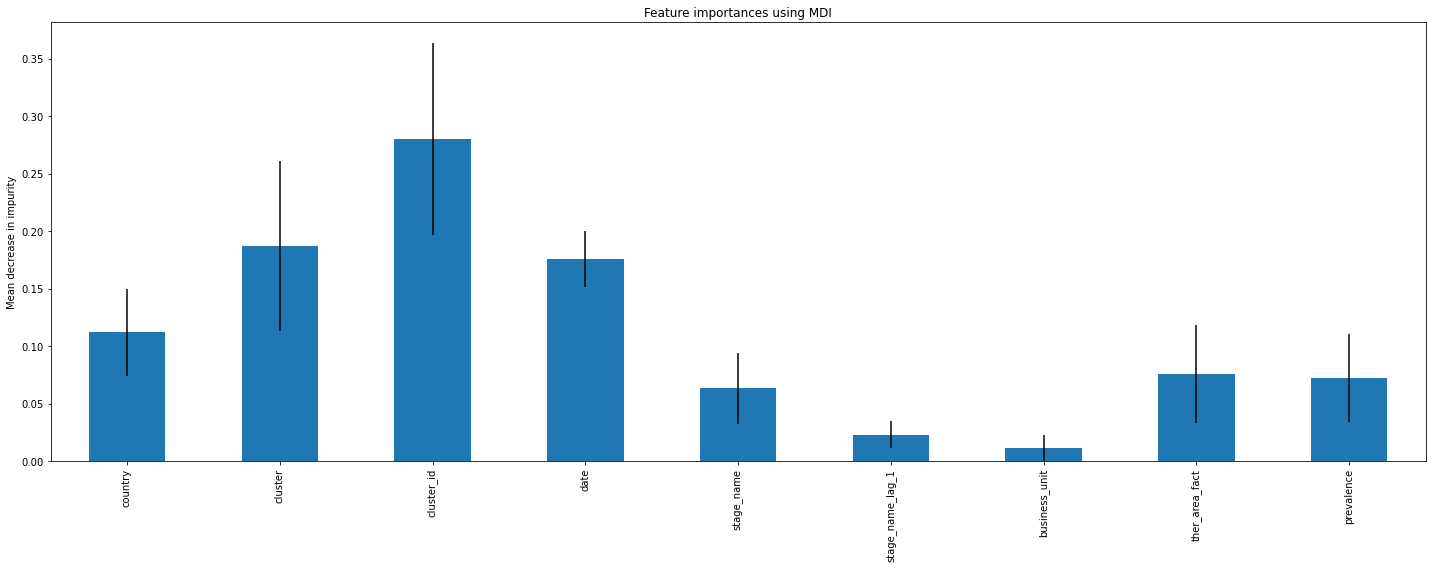

In [54]:
X=pd.DataFrame(X)

features= list(X.columns)
start_time = time.time()
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_], axis=0)
elapsed_time = time.time() - start_time

forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots(figsize=(20,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**We can also test other models before making conclusions**

In [55]:
reg=XGBRegressor()

In [56]:
reg.fit(X_train,y_train).score(X_test,y_test)

0.9428751505332575

**Our random forest regressor was slightly better**

In [57]:
df

,cluster_id,date,forecast
0,170,0,NaN
1,170,1,NaN
2,170,2,NaN
3,170,3,NaN
4,170,4,NaN
...,...,...,...
8357,165,32,NaN
8358,165,33,NaN
8359,165,34,NaN
8360,165,35,NaN


In [58]:
X

,country,cluster,cluster_id,date,stage_name,stage_name_lag_1,business_unit,ther_area_fact,prevalence
0,0,98,1010,0,5,6,1,1,-1.0
1,0,98,1010,1,5,6,1,1,-1.0
2,0,98,1010,2,5,6,1,1,-1.0
3,0,98,1010,3,5,6,1,1,-1.0
4,0,98,1010,4,5,6,1,1,-1.0
...,...,...,...,...,...,...,...,...,...
147392,28,19,1138,119,1,1,1,7,-1.0
147393,28,19,1138,120,1,1,1,7,-1.0
147394,28,19,1138,121,1,1,1,7,-1.0
147395,28,19,1138,122,1,1,1,7,-1.0


In [59]:
df_pred = X.merge(df.drop(columns=["date","forecast"]),on='cluster_id',how='left')
df_pred

,country,cluster,cluster_id,date,stage_name,stage_name_lag_1,business_unit,ther_area_fact,prevalence
0,0,98,1010,0,5,6,1,1,-1.0
1,0,98,1010,1,5,6,1,1,-1.0
2,0,98,1010,2,5,6,1,1,-1.0
3,0,98,1010,3,5,6,1,1,-1.0
4,0,98,1010,4,5,6,1,1,-1.0
...,...,...,...,...,...,...,...,...,...
922508,28,19,1138,119,1,1,1,7,-1.0
922509,28,19,1138,120,1,1,1,7,-1.0
922510,28,19,1138,121,1,1,1,7,-1.0
922511,28,19,1138,122,1,1,1,7,-1.0


In [60]:
volume_pred = reg.predict(df_pred)

In [61]:
df_final = pd.DataFrame(volume_pred)
df_final["cluster_id"]=df_pred["cluster_id"]

Calculating the mean for each case

In [62]:
df_final

,0,cluster_id
0,-8.769530e+09,1010
1,-8.137677e+09,1010
2,4.818740e+09,1010
3,-8.265590e+08,1010
4,-4.623500e+09,1010
...,...,...
922508,-4.944366e+09,1138
922509,-4.944366e+09,1138
922510,-4.944366e+09,1138
922511,-4.944366e+09,1138


In [63]:
List_final=[]
for x in submission_metric_two_template["cluster_id"]:
    List_final.append(np.mean(df_final[df_final["cluster_id"] == x ])[0])

In [64]:
pd.DataFrame(List_final).describe() # Final result

,0
count,8.362000e+03
mean,1.486401e+11
std,6.610724e+11
min,-2.847271e+10
25%,-2.011672e+09
50%,7.020383e+09
75%,3.266983e+10
max,5.619257e+12


In [65]:
submission_metric_two_template["forecast"]=List_final

In [66]:
submission_metric_two_template.describe()

,cluster_id,date,forecast
count,8362.000000,8362.000000,8.362000e+03
mean,112.500000,18.000000,1.486401e+11
std,65.243843,10.677717,6.610724e+11
min,0.000000,0.000000,-2.847271e+10
25%,56.000000,9.000000,-2.011672e+09
50%,112.500000,18.000000,7.020383e+09
75%,169.000000,27.000000,3.266983e+10
max,225.000000,36.000000,5.619257e+12


In [67]:
submission_metric_one_template.to_csv("Attempt_Metric2.csv")

___

# END OF THE DATATHON